In [4]:
import utils.unet_utils as ut
import torch.nn as nn
import torch.optim as optim
import torch
from torch.utils.data import DataLoader
from utils.unet_utils import train
from DataSet import ImSegDataSet
import time
!pip install -U segmentation-models-pytorch
import segmentation_models_pytorch as smp

  Using cached https://files.pythonhosted.org/packages/40/7d/6a91c9608fd54c115e617e233c44b7023dc4445d478b258d04314afbd02a/segmentation_models_pytorch-0.3.2-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/bc/07/830784e061fb94d67649f3e438ff63cfb902dec6d48ac75aeaaac7c7c30e/Pillow-9.4.0.tar.gz
  Using cached https://files.pythonhosted.org/packages/89/4e/97622efc48a6e0c11781ed8a3472c679f2c8a5cf6ebd58a57b050e758bfe/timm-0.6.12-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/8a/88/e83d51deb96de0847884fddb82ac0958fdc06f814c846878489aa5857a91/torchvision-0.14.1-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/cc/ab/85d8da5c9a45e072301beb37ad7f833cd344e04c817d97e0cc75681d248f/munch-2.5.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/d9/5a/e7c31adbe875f2abbb91bd84cf2dc52d792b5a01506781dbcf25c91daf11/six-1.16.0-py2.py3-none-any.whl
  ERROR: Command errored out with exit status 1:
  

ModuleNotFoundError: No module named 'segmentation_models_pytorch'

In [6]:
def initialize_weights(m):
  if isinstance(m, nn.Conv2d):
      nn.init.xavier_normal_(m.weight.data)
  elif isinstance(m, nn.ConvTranspose2d):
      nn.init.xavier_normal_(m.weight.data)

#########################################################################################
INFO ABOUT THE DATA SET:
	Mode of the data set:	train
	Number of instances:	300
	Image: (C,H,W):		(3,4000,6000)
#########################################################################################


#########################################################################################
INFO ABOUT THE DATA SET:
	Mode of the data set:	validation
	Number of instances:	50
	Image: (C,H,W):		(3,4000,6000)
#########################################################################################
Epoch: 1 



100%|██████████| 300/300 [07:48<00:00,  1.56s/it]


Epoch: 2 



100%|██████████| 300/300 [07:23<00:00,  1.48s/it]


TypeError: 'AxesSubplot' object is not subscriptable

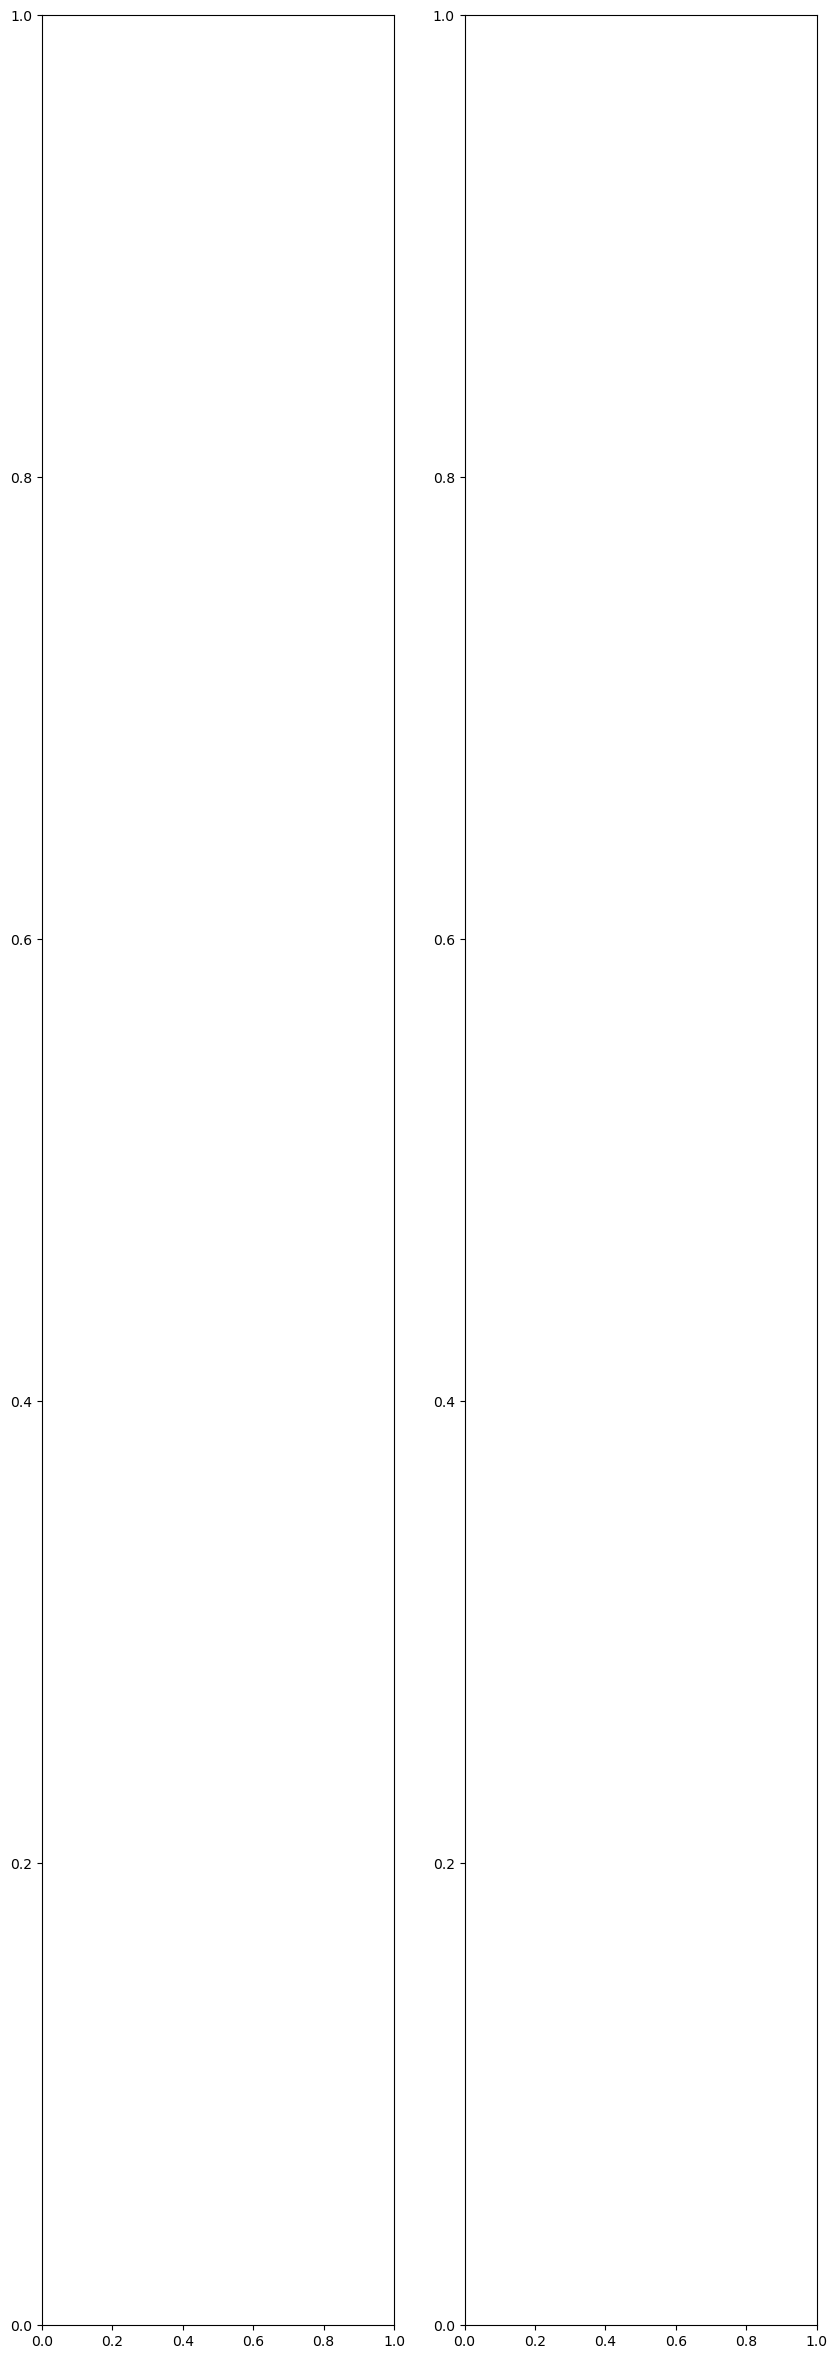

In [2]:
#Use the cross entropy loss, since we have more than two classes per pixel
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def CriterionCombo(input,target):

    #Get One Hot encoding of the true labels
    y_true = torch.nn.functional.one_hot(target,24).permute(0,3,1,2).float()

    assert y_true.shape == input.shape
    
    BCELoss = smp.losses.SoftBCEWithLogitsLoss()
    TverskyLoss = smp.losses.TverskyLoss(mode = 'multilabel', log_loss = False)

    L1 = BCELoss(y_pred = input,y_true = y_true)
    L2 = TverskyLoss(y_pred = input,y_true = y_true)

    loss = 0.5 * L1 + 0.5 * L2

    return loss

crit = CriterionCombo

model = ut.UNet(3, 24, [64, 128, 256, 512]).to(device)
model.apply(initialize_weights)
optimizer = optim.Adam(model.parameters(), lr = 0.0001)

#Data set and data loader for the training set
DS_training = ImSegDataSet(PathToDataSet="./data/train_set/",mode = "train")
DL_training = DataLoader(dataset=DS_training,batch_size=1,shuffle=True)

#Data set and data loader for the validation set
print("\n")
DS_validation = ImSegDataSet(PathToDataSet="./data/validation_set/",mode = "validation")
DL_validation = DataLoader(dataset=DS_validation,batch_size=5)

'''
result = train(
    model = model, 
    dataloader_training = DL_training, 
    dataLoader_validation = DL_validation,
    optimizer = optimizer, 
    criterion = crit, 
    device = device, 
    buffer_size = 5, 
    buffer_update_freq = 5,
    buffer_pick_size = 3,
    n_epochs = 5,
    patch_size = 32,
    tag = "test_run_1_2023-03-20"
    )
'''

result = train(
    model = model, 
    dataloader_training = DL_training, 
    dataLoader_validation = DL_validation,
    optimizer = optimizer, 
    criterion = crit, 
    device = device, 
    buffer_size = 1, 
    buffer_update_freq = 1,
    buffer_pick_size = 1,
    n_epochs = 5,
    patch_size = 256,
    tag = "test{}".format(time.strftime("%d-%H%M%S", time.gmtime(time.time()))),
    rotation = True,
    mirroring = False
    )

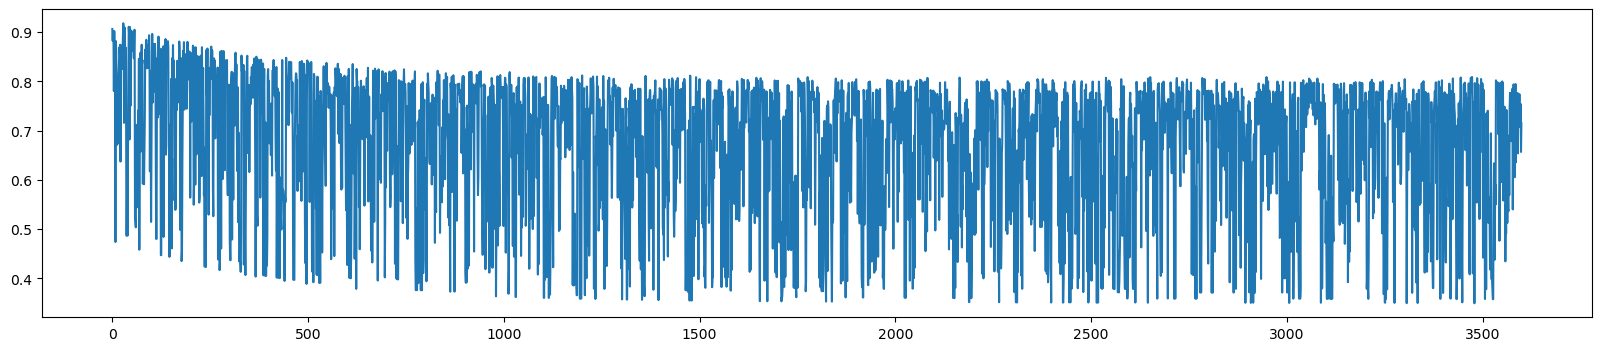

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,4)
loss = np.loadtxt("./results/test26-170413/data/training_loss.txt", skiprows=1)
plt.plot(np.arange(len(loss)), loss)